# <center> Логистическая регрессия

## Создание данных

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
cluster_len = 50

X1 = np.random.multivariate_normal([0, 0], [[2, 0], [0, 2]], size=cluster_len)
y1 = np.zeros(len(X1))

X2 = np.random.multivariate_normal([4, 4], [[2, 0], [0, 2]], size=cluster_len)
y2 = np.ones(len(X2))

X3 = np.random.multivariate_normal([4, -4], [[2, 0], [0, 2]], size=cluster_len)
y3 = np.ones(len(X3)) * 2

X = np.concatenate((X1, X2, X3), axis=0)
y = np.concatenate((y1, y2, y3), axis=0)

Z = list(zip(X, y))
random.shuffle(Z)
X, y = zip(*Z)
X = np.array(X)
y = np.array(y)

Визуализируем наши данные

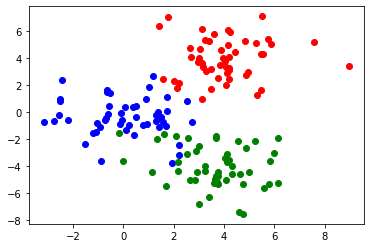

In [3]:
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'ob')
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'or')
plt.plot(X[:, 0][y==2], X[:, 1][y==2], 'og')
# plt.xlim([-5, 9])
# plt.ylim([-5, 9])
plt.show()

Разобьем данные на train и test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Реализация

In [5]:
class multiclass_logistic:
    def __init__(self, C=None):
        self.w = None
        X_bias = np.concatenate((X, np.ones((len(X), 1))), axis = 1)
        if C is not None:
            self.C = C
        else:
            self.C = float('inf')
        self.L = np.zeros(2000)        
        
    def encoded(self, Y):
        '''
        Мы хотим, чтобы наша модель работала как библиотечная модель. 
        Поэтому мы хотим, чтобы целевая переменная была одномерной.
        Но в реализации целевая переменная нам нужна в виде one-hot. 
        Именно эту операцию выполняет данная функция.
        '''
        content = np.unique(Y)
        dict_one_hot = {}
        for i in range(len(content)):
            a = np.zeros(len(content))
            a[i] = 1
            dict_one_hot[content[i]] = a
        encode = np.zeros((len(Y), len(dict_one_hot)))
        for i in range(len(Y)):
            encode[i] = dict_one_hot[Y[i]]
        return encode
        
    def return_probs(self, X):
        '''
        Данная функция возвращает нам матрицу (k, m)-ый элемент которого есть вероятность того,
        что k-ый элемент принадлежит к m-ому классу.
        '''
        X_bias = np.concatenate((X, np.ones((len(X), 1))), axis = 1)
        probs = np.zeros((np.size(X_bias, 0), np.size(self.w, 1)))
        for i in range(len(probs)):
            probs[i] = np.exp(-np.dot(X_bias[i], self.w)) / np.sum(np.exp(-np.dot(X_bias[i], self.w)))
        return probs
    
    def Loss(self, X, y):
        '''
        Данная функция считает ошибку.
        '''
        y_encoded = self.encoded(y)
        X_bias = np.concatenate((X, np.ones((len(X), 1))), axis = 1)
        probs = self.return_probs(X=X)
        L = np.trace(np.dot(X_bias, np.dot(self.w, np.transpose(y_encoded))))
        for i in range(len(X_bias)):
            L += np.log(np.sum(np.exp(np.dot(-X_bias[i], self.w))))
        return L
    
    def Grad_Loss(self, X, y):
        '''
        Данная функция считает градиент ошибки по матрицу весов.
        '''
        y_encoded = self.encoded(y)
        X_bias = np.concatenate((X, np.ones((len(X), 1))), axis = 1)
        return np.dot(np.transpose(X_bias), y_encoded - self.return_probs(X=X)) / len(X_bias) +  self.w / self.C / len(X_bias)
    
    def fit(self, X, y, lr=0.02, max_iter=1000):
        '''
        Данная функция отвечает за обучение модели используя обычный градиентный спуск.
        '''
        y_encoded = self.encoded(y)
        if self.w is None:
            self.w = np.random.randn(np.size(X, 1)+1, np.size(y_encoded, 1))
        for i in range(max_iter):
            self.w -= lr * self.Grad_Loss(X=X, y=y)
            self.L[i] = self.Loss(X, y)
    
    def predict(self, X_train):
        '''
        Данная функция делает предсказывания.
        '''
        probs = self.return_probs(X=X_train)
        y_pred = probs.argmax(axis=1)
        return y_pred

## Эффект регуляризации

Для визуализации эффекта регуляризации изобразим зависимости ошибки от шага итерации и области решений. Также проверим что коэффициенты матрицы весов при регуляризации L2 становиться меньше.

In [6]:
#Случай без регуляризации
logistic_casual = multiclass_logistic()
logistic_casual.fit(X_train, y_train)
L_casual = logistic_casual.L
#Случай с регуляризацией
logistic_l2 = multiclass_logistic(C=0.001)
logistic_l2.fit(X_train, y_train)
L_l2 = logistic_l2.L

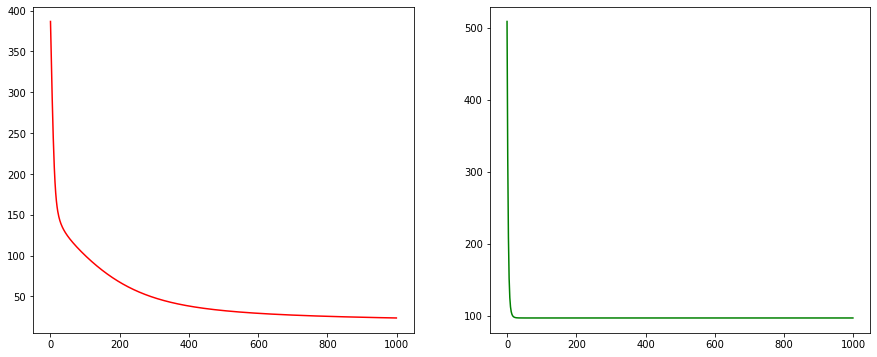

In [7]:
f = plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(range(len(L_casual[0:1000])), L_casual[0:1000], color="red")

plt.subplot(122)
plt.plot(range(len(L_l2[0:1000])), L_l2[0:1000], color="green")

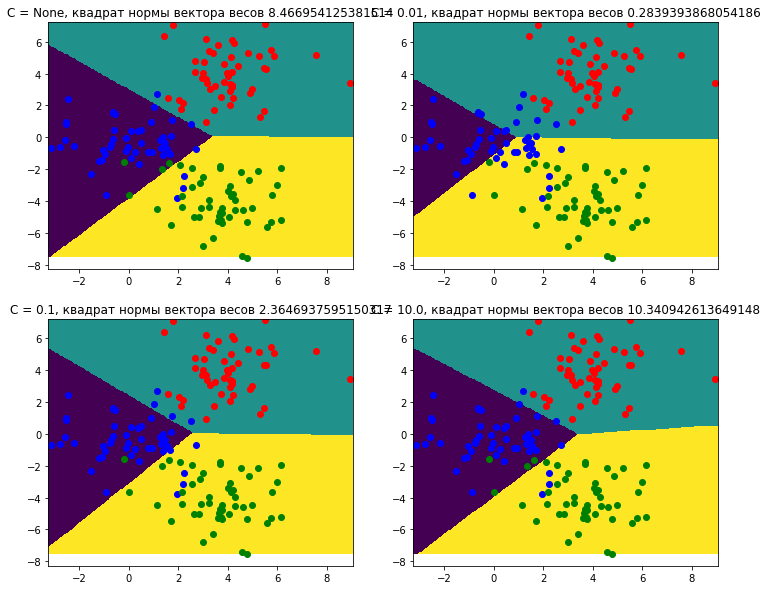

In [8]:
plt.figure(figsize=(12, 10))
C = [None, 0.01, 0.1, 10.0]
for i in range(len(C)):
    logistic = multiclass_logistic(C[i])
    logistic.fit(X_train, y_train)
    
    eps = 0.1
    xx, yy = np.meshgrid(np.linspace(np.min(X_train[:,0]) - eps, np.max(X_train[:,0]) + eps, 300),
                     np.linspace(np.min(X_train[:,1]) - eps, np.max(X_train[:,1]) + eps, 300))
    
    preds = logistic.predict(np.stack([xx.reshape(-1), yy.reshape(-1)], axis=1))
    
    preds = preds.reshape(xx.shape)
    
    plt.subplot(221 + i)
    plt.title('C = {}, квадрат нормы вектора весов {}'.format(C[i], (np.dot(logistic.w.flatten(), logistic.w.flatten()))))
    
    plt.pcolormesh(xx, yy, preds)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'ob')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'or')
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], 'og')
    
plt.show()

##  Сравнение модели с моделей sklearn

Будем следить за метрикой accuracy

Случай отсутствии регуляризации

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [10]:
clf = LogisticRegression().fit(X_train, y_train)

In [11]:
y_pred_sklearn = clf.predict(X_test)

In [12]:
print('Значение accuracy на test-е библиотеки sklearn равна {}'.format(accuracy_score(y_test, y_pred_sklearn)))

Значение accuracy на test-е библиотеки sklearn равна 0.9333333333333333


In [13]:
logistic = multiclass_logistic()
logistic.fit(X_train, y_train)

In [14]:
y_pred_my_log_reg = logistic.predict(X_test)

In [15]:
print('Значение accuracy на test-е нашей модели равна {}'.format(accuracy_score(y_test, y_pred_my_log_reg)))

Значение accuracy на test-е нашей модели равна 0.9


Случай регуляризации

In [16]:
clf_l2 = LogisticRegression(C=1).fit(X_train, y_train)

In [17]:
y_pred_sklearn_l2 = clf_l2.predict(X_test)

In [18]:
print('Значение accuracy на test-е библиотеки sklearn равна {}'.format(accuracy_score(y_test, y_pred_sklearn_l2)))

Значение accuracy на test-е библиотеки sklearn равна 0.9333333333333333


In [19]:
logistic_l2 = multiclass_logistic(C=1)
logistic.fit(X_train, y_train)

In [20]:
y_pred_my_log_reg_l2 = logistic.predict(X_test)

In [21]:
print('Значение accuracy на test-е библиотеки sklearn равна {}'.format(accuracy_score(y_test, y_pred_my_log_reg_l2)))

Значение accuracy на test-е библиотеки sklearn равна 0.9333333333333333


## Итог

1) Была реализована многоклассовая логистическая регрессия. В качестве регуляризации использовалось L2.


2) Оказалось, что эффект регуляризации виден на зависимости ошибки от шага итерации, области решений и значений матрицы весов. В области решений разделяющие кривые оказались прямыми из-за одинакового нормального распределения классов.

3) Значение метрики accuracy нашей модели и модели sklearn оказались очень близки как в случае регуляризации, так и без него.